# Imports

In [66]:
reload = False
if reload: 
    !lsof /dev/nvidia* | awk '{print $2}' | xargs -I {} kill {}

In [67]:
# EXTERNAL LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yaml
from pathlib import Path
import os
import sys

# MY SCRIPTS
sys.path.append('functions/') # scripts folder
import plots
import system as syst
import qammod as qmd
import papreduce as prd
import ccdf as ccdf
import file as f

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
    print('You are going to use GOOGLE COLAB')
except ImportError:
    IN_COLAB = False
    print('You are going to use LOCAL MACHINE')

# Add path for scripts and files directory
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    AUX_DATA_ROOT = Path("/content/drive/My Drive/PAPR reduction/Code")
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = ''
    
CFG_PATH = os.path.join(AUX_DATA_ROOT, 'config.yaml')
      
if torch.cuda.is_available():
    device=torch.device('cuda')
    print('You are going to use CUDA')
else:
    device=torch.device('cpu')
    print('You are going to use CPU')
    
%load_ext autoreload
%autoreload 2

You are going to use LOCAL MACHINE
You are going to use CUDA
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load system's configuration

In [68]:
# OPEN CONFIGURATION FILE
with open('config.yaml','r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    print('Config has been readed successfully')

# edit configuration
cfg['N_UE'] = 5
# cfg['N_fft'] = 300
# cfg['N_used'] = 120
# cfg['N_zero'] = 180
# cfg['N_RB'] = 10
# cfg['M'] = 1000
cfg['RNG_SEED'] = 1
cfg['P_SEED'] = 2
cfg['M_SEED'] = 3
cfg['RB_SEED'] = 4

# show system's configuration
display(cfg)

# set random seed
# torch.manual_seed(cfg['SEED'])
# np.random.seed(cfg['SEED'])

# load complex and decimal modulation constellations
constellations = qmd.load_constellations(config=cfg,device=device,info=True)

# load Fourier matrix
S_sc = prd.gen_fourier_matrix(config=cfg,device=device)

# PAPR range for CCDF
PAPR_RANGE = torch.arange(0,12.25,step=0.25)

# zero shift to center spectrum
ZERO_SHIFT = cfg['N_zero']//2

CCDF_SIZE = (8,5)
PSD_SIZE = (10,6)

Config has been readed successfully


{'Fs': 15.36,
 'N_UE': 5,
 'P_UE_max_min': 100,
 'P_TX': 100,
 'N_fft': 1024,
 'N_used': 600,
 'N_zero': 424,
 'N_RB': 50,
 'EVM_QPSK': 17.5,
 'EVM_QAM16': 12.5,
 'EVM_QAM64': 8,
 'EVM_QAM256': 3.5,
 'EVM_QAM1024': 1,
 'M': 500,
 'N_SC_RB': 12,
 'RNG_SEED': 1,
 'P_SEED': 2,
 'M_SEED': 3,
 'RB_SEED': 4}

The following constelletions have been loaded: ['QPSK', 'QAM16', 'QAM64', 'QAM256', 'QAM1024']


# Power allocation
# Modulation type allocation, EVM allocation
# Allowed noise level allocation(calculation)
# Resourse block allocation

In [69]:
PTX_allocation = syst.PTX_allocate(config=cfg,info=True)
PTX_allocation = np.array([17,25,17,25,16])
# PTX_allocation = np.array([33,33,34])

MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=True)

ANL_allocation_P,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

RB_allocation = syst.RB_allocate(config=cfg,info=True)

UE power has been allocated - OK:
Max UE power can be:     96.154
Min UE power can be:      0.962
Sum UE power can be:    100.000
Current Ptx allocation: [23.  5. 27. 23. 22.]
Sum UE power is:        100.000

MODs have been allocated - OK:
Current MODs allocation: ['QAM64', 'QPSK', 'QAM16', 'QAM256', 'QPSK']
Current EVMs allocation: [ 8.  17.5 12.5  3.5 17.5]

Allowed noise level allocation: [-29.634 -21.16  -25.757 -35.139 -23.098] dB
                                [3.298 8.75  5.154 1.75  7.   ] %

RBs have been allocated - OK:
Current RB allocation: [12  8 12  9  9]
Sum UE RB is: 50



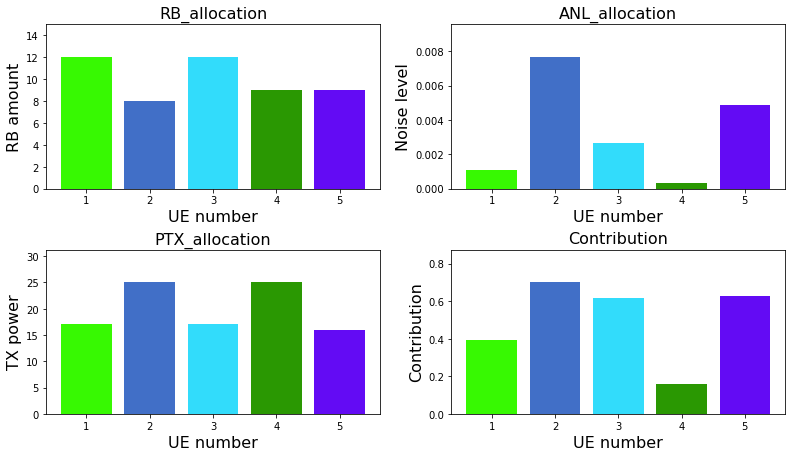

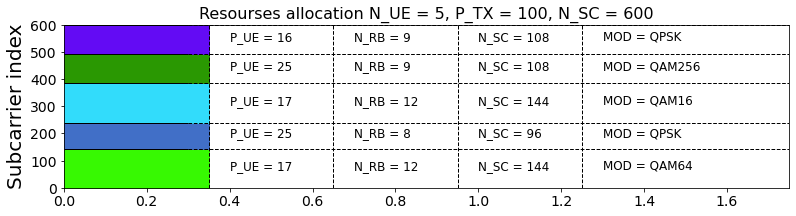

In [70]:
color_list = plots.plot_allocations(RB_allocation,PTX_allocation,ANL_allocation)
plots.plot_res_allocation(np.array(PTX_allocation),np.array(RB_allocation),MOD_allocation,color_list,cfg)

# OFDM signal generation

# Check PAPR

In [71]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
# generate data points
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
# modulate them
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True)
# find mean PAPR
PAPR = syst.get_signal_PAPR(S_t)
PAPR_mean0 = PAPR.mean()
PAPR_max0 = PAPR.max()
max_papr_idx0 = torch.argmax(PAPR)
print('Initial mean PAPR is ',PAPR_mean0)
print('Initial max PAPR is ',PAPR_max0,max_papr_idx0)

The signal has been generated:
Total power =              100.000
OFDM symbols:                  500
IFFT length:                 1024
Mean power in freq dommain = 11.449
Mean power in time dommain = 11.449
Initial mean PAPR is  tensor(8.6783, device='cuda:0')
Initial max PAPR is  tensor(11.3692, device='cuda:0') tensor(170, device='cuda:0')


# Max and min PAPR OFDM symbol

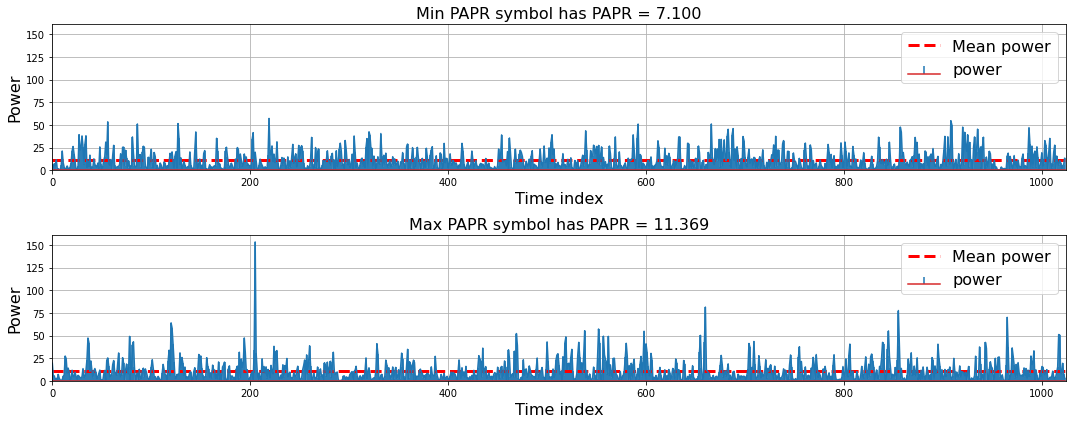

In [72]:
min_papr,max_papr = plots.find_max_min_papr_symbol(S_t,S_f,PAPR)
plots.plot_maxminpapr(min_papr,max_papr,figsize=(15,6))

# PAPR probability density function (PDF)

In [73]:
# a = []
# for i in range(1000):
#     cfg['RNG_SEED'] = i
#     torch.cuda.ipc_collect()
#     torch.cuda.empty_cache()
#     D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
#     S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
#     PAPR,PAPR_mean0,_ = syst.get_signal_PAPR(S_t)
#     a.extend(np.copy(PAPR.cpu()))

In [74]:
# bins = 300
# plt.figure(figsize=(12,3))
# plt.title('OFDM signal PAPR PDF',fontsize=16)
# plt.xlabel('PAPR value',fontsize=16)
# plt.ylabel('Probability',fontsize=16)

# h = plt.hist(np.array(a).reshape(-1,1)[:], bins, label='Signal amplitude')
# # plt.legend(loc='upper right', prop={'size': 14})
# plt.xlim(4,12)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

# th = 4

In [75]:
i=0

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# select subcarriers for PAPR reduction
G0_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
peak_th = 4
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=True)

Consider as peaks signals exceeding (of mean power):  2.51188643150958
Pdata/Ptones before supression [-6.8  -8.38 -7.7  -6.43 -7.72 -7.43 -7.02 -7.66 -7.72 -7.2  -7.53 -6.43
 -6.46 -6.83 -7.35 -6.69 -7.22 -7.06 -7.15 -6.75 -7.25 -8.21 -7.26 -7.54
 -7.22 -7.03 -7.42 -7.84 -6.93 -7.99 -6.88 -6.72 -7.02 -6.39 -6.37 -7.5
 -8.42 -6.63 -6.47 -7.46 -7.28 -6.31 -6.96 -7.29 -6.89 -7.45 -6.57 -8.13
 -6.46 -8.34 -7.33 -6.93 -6.49 -6.62 -6.36 -6.88 -6.82 -8.17 -7.79 -7.58
 -8.01 -6.61 -6.7  -8.43 -7.34 -7.24 -6.3  -8.   -6.9  -6.88 -7.37 -7.44
 -7.53 -6.38 -7.15 -7.61 -7.06 -7.21 -7.41 -6.56 -6.56 -6.93 -7.09 -6.39
 -7.67 -6.99 -7.5  -6.73 -7.31 -6.49 -7.56 -7.67 -7.32 -7.5  -7.9  -7.17
 -6.42 -8.08 -6.26 -7.55 -6.64 -7.56 -6.98 -7.03 -6.91 -7.65 -7.25 -7.94
 -6.81 -7.22 -6.72 -7.7  -6.78 -7.49 -7.54 -7.32 -7.31 -6.9  -6.76 -7.2
 -6.83 -7.45 -7.5  -7.3  -7.74 -7.14 -7.56 -7.07 -7.15 -7.01 -7.08 -7.47
 -7.12 -7.03 -7.87 -6.99 -8.07 -6.99 -8.13 -7.36 -7.62 -7.36 -7.59 -6.88
 -7.47 -7.68 -7.94 -7.19

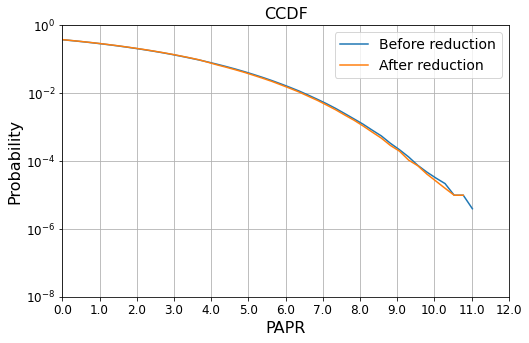

Mean PAPR before reduction: tensor(8.6783, device='cuda:0')
Mean PAPR after reduction: tensor(8.6044, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.0739, device='cuda:0') dB
Max PAPR has been reduced by:  tensor(0.0624, device='cuda:0') dB


In [76]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [plots.filter_ccdf(CCDF1),plots.filter_ccdf(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR has been reduced by: ',PAPR_max0-PAPR[max_papr_idx0],'dB')

# th = 6

In [77]:
i=1

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# select subcarriers for PAPR reduction
G0_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT

# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
peak_th = 6
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)

Consider as peaks signals exceeding (of mean power):  3.9810717055349722


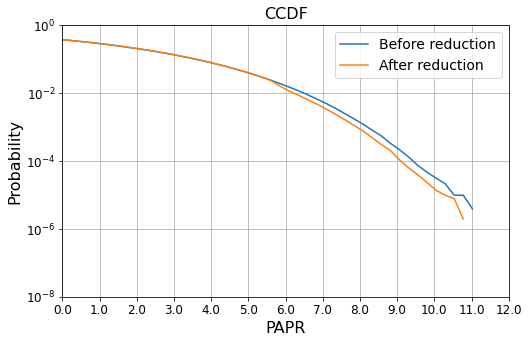

Mean PAPR before reduction: tensor(8.6783, device='cuda:0')
Mean PAPR after reduction: tensor(8.3645, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.3138, device='cuda:0') dB
Max PAPR has been reduced by:  tensor(0.1996, device='cuda:0') dB


In [78]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [(CCDF1),(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR has been reduced by: ',PAPR_max0-PAPR[max_papr_idx0],'dB')

# th = 8

In [79]:
i=2

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# select subcarriers for PAPR reduction
G0_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT

# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
peak_th = 8
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
# S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC[:300],S_sc,cfg,info=False)

Consider as peaks signals exceeding (of mean power):  6.309573444801933


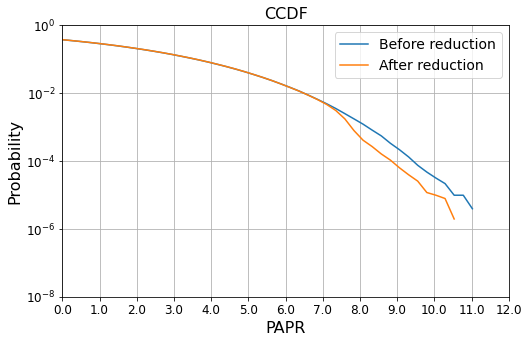

Mean PAPR before reduction: tensor(8.6783, device='cuda:0')
Mean PAPR after reduction: tensor(8.1670, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.5113, device='cuda:0') dB
Max PAPR has been reduced by:  tensor(0.4977, device='cuda:0') dB


In [80]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [(CCDF1),(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR has been reduced by: ',PAPR_max0-PAPR[max_papr_idx0],'dB')

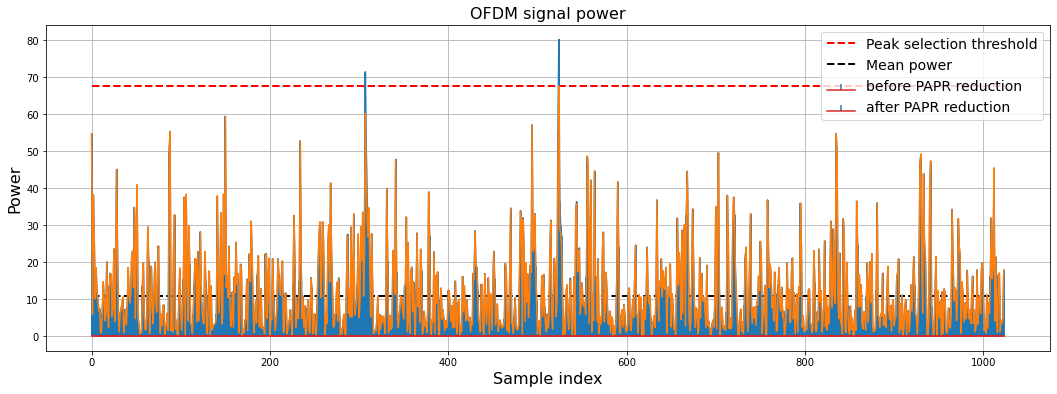

In [81]:
plt.figure(figsize=(18,6))
plt.title('OFDM signal power',fontsize=16)
plt.hlines(np.mean(np.abs(np.array(S_t[1,:].cpu()))**2)*10**(peak_th/10),0,len(S_t),'r','--',linewidth=2,label='Peak selection threshold')
plt.hlines(np.mean(np.abs(np.array(S_t[1,:].cpu()))**2),0,len(S_t),'k','--',linewidth=2,label='Mean power')

plt.stem(np.arange(1024),abs(S_t[:,0].cpu())**2,markerfmt='',label='before PAPR reduction')
plt.stem(np.arange(1024),abs(S_t_reduced[:,0].cpu())**2,markerfmt='',label='after PAPR reduction')
# plt.plot(abs(S_t[:,0].cpu())**2,label='before PAPR reduction')
# plt.plot(abs(S_t_reduced[:,0].cpu())**2,label='after PAPR reduction')
plt.legend(loc='upper right', prop={'size': 14})
plt.xlabel('Sample index',fontsize=16)
plt.ylabel('Power',fontsize=16)
plt.grid()

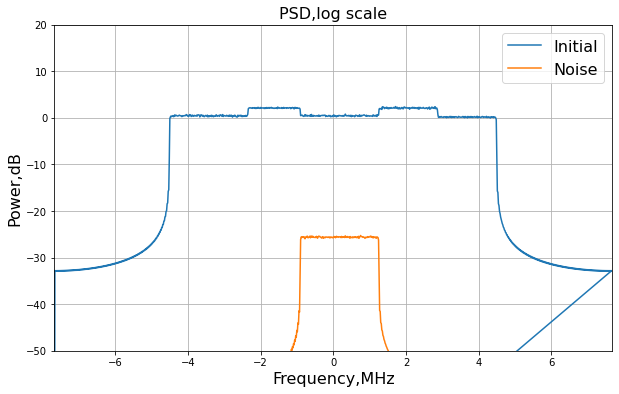

(['QAM64', 'QPSK', 'QAM16', 'QAM256', 'QPSK'],
 array([-29.63371105, -21.15983894, -25.75731053, -35.13923903,
        -23.0980392 ]))

In [82]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLE='PSD,log scale'

PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,cfg,PSD_SIZE)
MOD_allocation,10*np.log10(ANL_allocation)

Allowed EVM =  -23.09803919971486
Real    EVM =  -32.82466506757893


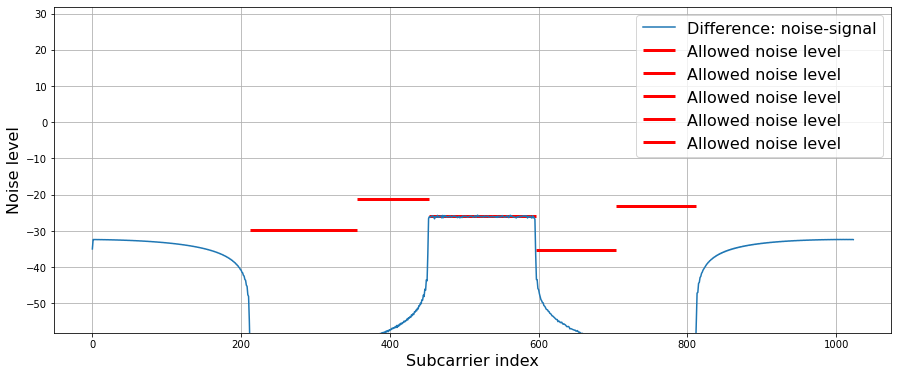

In [83]:
sc=np.arange(len(S_t))
plt.figure(figsize=(15,6))
psd = -10*np.log10(PSD[0][0][sc])+10*np.log10(PSD[1][0][sc])
plt.plot(psd,label = 'Difference: noise-signal')
SC = syst.GET_UE_SC_idx(torch.tensor(RB_allocation))+ZERO_SHIFT
# plt.vlines(np.array([ZERO_SHIFT,ZERO_SHIFT+cfg['N_used']]),-50,10,colors='k',linewidth=0.5)
for i in range(len(SC)-1):
    plt.hlines(10*np.log10(ANL_allocation[i]),SC[i],SC[i+1],colors='r',linewidth=3,label = 'Allowed noise level')
    
plt.ylabel('Noise level',fontsize=16)
plt.xlabel('Subcarrier index',fontsize=16)
plt.ylim(10*np.log10(ANL_allocation[i])-35,10*np.log10(ANL_allocation[i])+55)
plt.legend(fontsize=16)
plt.grid()

print('Allowed EVM = ',10*np.log10(ANL_allocation[i]))
print('Real    EVM = ',10*np.log10((torch.sum(torch.abs(S_t_reduced - S_t)**2)/torch.sum(torch.abs(S_t)**2)).cpu().item()))

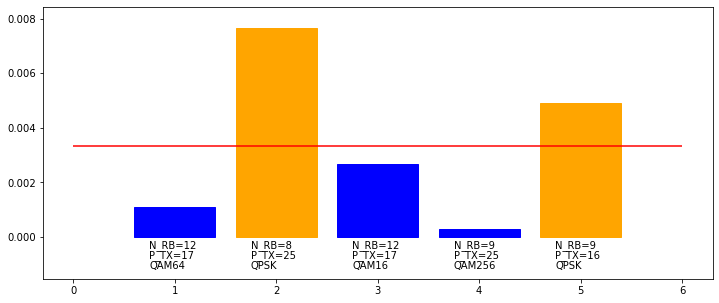

In [84]:
k=1
th = k*np.mean(ANL_allocation)

plt.figure(figsize=(12,5))
plt.hlines(th,0,cfg['N_UE']+1,'r')
plt.ylim(-0.2*np.max(ANL_allocation),1.1*np.max(ANL_allocation))

bar = plt.bar(np.arange(cfg['N_UE'])+1,ANL_allocation)

G1_UE_idx = np.nonzero(ANL_allocation > th)[0].astype(int)
G2_UE_idx = np.nonzero(ANL_allocation <= th)[0].astype(int)

# G1_UE_idx = np.array([0])
# G2_UE_idx = np.array([1])

for i in G1_UE_idx:
    bar[i].set_color('orange')
for i in G2_UE_idx:
    bar[i].set_color('blue')
    
for i in range(len(ANL_allocation)):
    plt.text(i+0.75,-0.05*np.max(ANL_allocation),'N_RB='+str(RB_allocation[i]))
    plt.text(i+0.75,-0.1*np.max(ANL_allocation),'P_TX='+str(PTX_allocation[i]))
    plt.text(i+0.75,-0.15*np.max(ANL_allocation),str(MOD_allocation[i]))

# PAPR reduction for several groups

In [85]:
G1_UE_idx_ = np.array([0])
G2_UE_idx_ = np.array([1])
G3_UE_idx_ = np.array([2])
G4_UE_idx_ = np.array([3])
G5_UE_idx_ = np.array([4])

th = 6.64
ths = [7.68,7.35,6.99,6.69,6.51]
# select option: common threshold|different thresholds
OPTION = ['single_th','different_ths'][1]

peak_th = ths[0]
if OPTION == 'single_th': peak_th = th
G1_group_th = ANL_allocation[G1_UE_idx_][0]
G1_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G1_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G1_group_th,G1_SC,S_sc,cfg,info=False)

peak_th = ths[1]
if OPTION == 'single_th': peak_th = th
G2_group_th = ANL_allocation[G2_UE_idx_][0]
G2_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G2_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,G2_group_th,G2_SC,S_sc,cfg,info=False)

peak_th = ths[2]
if OPTION == 'single_th': peak_th = th
G3_group_th = ANL_allocation[G3_UE_idx_][0]
G3_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G3_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,G3_group_th,G3_SC,S_sc,cfg,info=False)

peak_th = ths[3]
if OPTION == 'single_th': peak_th = th
G4_group_th = ANL_allocation[G4_UE_idx_][0]
G4_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G4_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,G4_group_th,G4_SC,S_sc,cfg,info=False)

peak_th = ths[4]
if OPTION == 'single_th': peak_th = th
G5_group_th = ANL_allocation[G5_UE_idx_][0]
G5_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G5_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,G5_group_th,G5_SC,S_sc,cfg,info=False)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_papr_idx0],'dB')

Mean PAPR before reduction: tensor(8.6783, device='cuda:0')
Mean PAPR after reduction: tensor(6.9779, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.7004, device='cuda:0') dB
Max PAPR reduction:  tensor(1.4687, device='cuda:0') dB


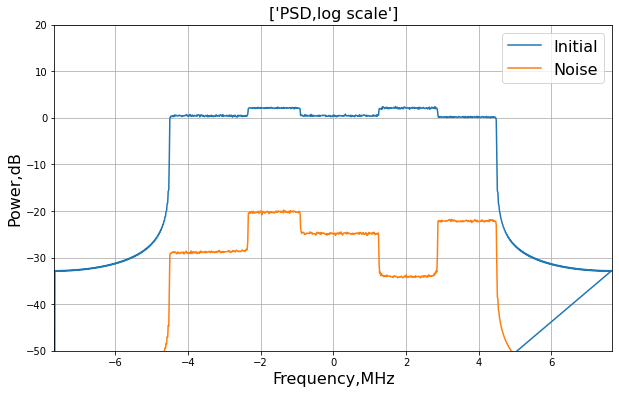

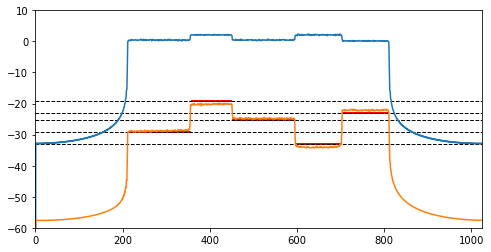

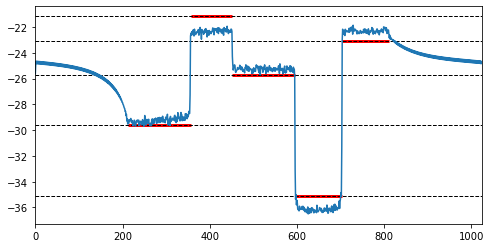

In [86]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES=['PSD,log scale']
PSD = plots.plot_spectrum(SIGNALS,LABELS,TITLES,cfg,PSD_SIZE)
plots.plot_PSD(ANL_allocation,SC,PSD,cfg)

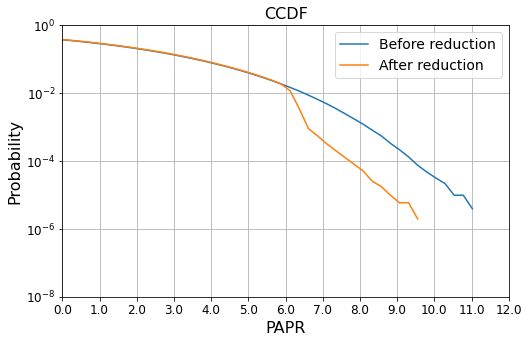

PAPR_mean before reduction tensor(8.6783, device='cuda:0')
PAPR_mean after reduction tensor(6.9779, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.7004, device='cuda:0')
Max PAPR reduction:  tensor(1.4687, device='cuda:0')


In [87]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean2 = PAPR.mean()
print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean2)
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_papr_idx0])

# Several thresholds

In [100]:
def find_opt_th(S_t,ue_idx,th_range):
    """
    Finds optimal peak selection threshold for a given signal S_t on subcarriers for given user
    """
    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}
    # select user
    G_UE_idx_= np.array([ue_idx])
    # select threshold
    G_group_th = ANL_allocation[G_UE_idx_][0]
    # select subcarriers
    G_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
    # find optimum
    for th in th_range:
        peak_th = th
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G_group_th,G_SC,S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean()
        PAPR_max = PAPR.max()
        res['mean'].append(PAPR_mean)
        res['max'].append(PAPR_max)
    ths['mean'] = th_range[np.argmin(res['mean'])]
    ths['max'] = th_range[np.argmin(res['max'])]
    return ths

In [101]:
class function(torch.nn.Module):
    def __init__(self,peak_th,G_group_th,G_SC,S_sc,cfg):
        super(function, self).__init__()
        self.peak_th = peak_th
        self.G_group_th = G_group_th
        self.G_SC = G_SC
        self.S_sc = S_sc
        self.cfg = cfg
        
    def forward(self, S_t):
        S_t_reduced = prd.PAPR_reduce(S_t,self.peak_th,self.G_group_th,self.G_SC,self.S_sc,self.cfg,info=False)
        return S_t_reduced

    def extra_repr(self):
        return 'opt_th={}'.format(self.peak_th)

PERMUTATION = ['direct','random','descending_anl','contribution'][2]
if PERMUTATION == 'direct':
    UE_order = np.arange(cfg['N_UE'])
elif PERMUTATION == 'random':
    UE_order = np.random.permutation(UE_order)
elif PERMUTATION == 'descending_anl':
    UE_order = ANL_allocation.argsort()[::-1]
elif PERMUTATION == 'contribution':
    UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
print('permutation order: ',UE_order)

th_range = np.linspace(6,10,201)
# find optimal th for the 1st layer (user)
th = find_opt_th(S_t,UE_order[0],th_range)
peak_th = th['mean']
G_UE_idx_= np.array([UE_order[0]])
G_group_th = ANL_allocation[G_UE_idx_][0]
G_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT

# create sequential container, add 1st layer
system = nn.Sequential()
system.add_module('layer_'+str(0),function(peak_th,G_group_th,G_SC,S_sc,cfg))

for i in range(1,cfg['N_UE']):
    # find optimal threshold for the 2..end layer (user)
    S_t_reduced = system.forward(S_t)
    th = find_opt_th(S_t_reduced,UE_order[i],th_range)
    peak_th = th['mean']
    G_UE_idx_= np.array([UE_order[i]])
    G_group_th = ANL_allocation[G_UE_idx_][0]
    G_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
    # add the 2nd..end layer
    system.add_module('layer_'+str(i),function(peak_th,G_group_th,G_SC,S_sc,cfg))
# reduce via the last layer
S_t_reduced = system.forward(S_t)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR_mean1.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_papr_idx0],'dB')
system.named_modules

permutation order:  [1 4 2 0 3]
Mean PAPR before reduction: tensor(8.6783, device='cuda:0')
Mean PAPR after reduction: tensor(6.9779, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.7004, device='cuda:0') dB
Max PAPR reduction:  tensor(1.6250, device='cuda:0') dB


<bound method Module.named_modules of Sequential(
  (layer_0): function(opt_th=7.54)
  (layer_1): function(opt_th=7.16)
  (layer_2): function(opt_th=6.68)
  (layer_3): function(opt_th=6.88)
  (layer_4): function(opt_th=6.5600000000000005)
)>

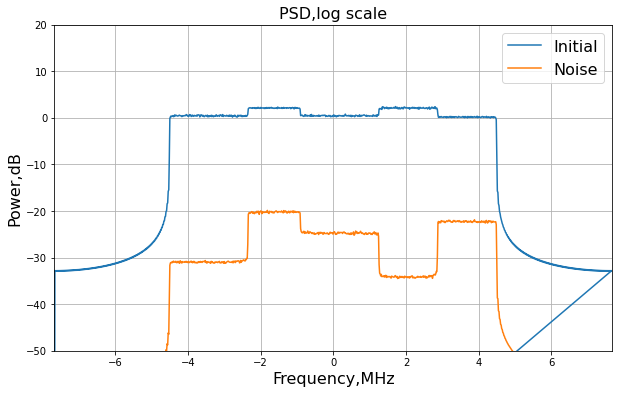

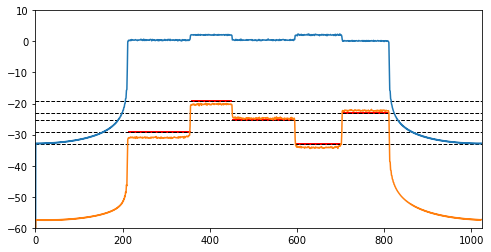

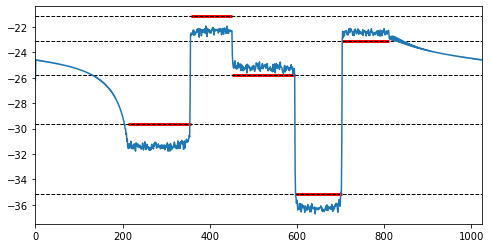

In [102]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES='PSD,log scale'
PSD = plots.plot_spectrum(SIGNALS,LABELS,TITLES,cfg,PSD_SIZE)
plots.plot_PSD(ANL_allocation,SC,PSD,cfg)

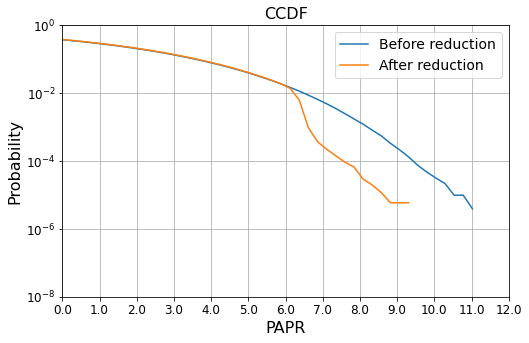

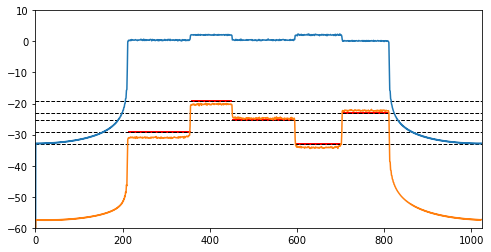

PAPR_mean before reduction tensor(8.6783, device='cuda:0')
PAPR_mean after reduction tensor(6.9020, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.7763, device='cuda:0')
Max PAPR reduction:  tensor(1.6250, device='cuda:0')


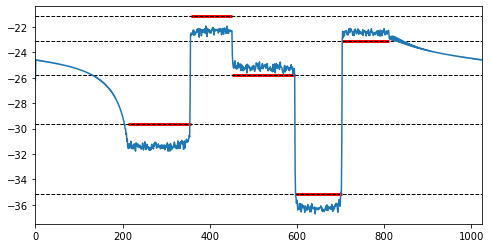

In [103]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)
plots.plot_PSD(ANL_allocation,SC,PSD,cfg)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean2 = PAPR.mean()
print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean2)
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_papr_idx0])

# One threshold

In [105]:
PERMUTATION = ['direct','random','descending_anl','contribution'][1]
if PERMUTATION == 'direct':
    UE_order = np.arange(cfg['N_UE'])
elif PERMUTATION == 'random':
    UE_order = np.random.permutation(UE_order)
elif PERMUTATION == 'descending_anl':
    UE_order = ANL_allocation.argsort()[::-1]
elif PERMUTATION == 'contribution':
    UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
print('permutation order: ',UE_order)

ths = {'mean':0,'max':0}
res = {'mean':[],'max':[]}
th_range = np.linspace(6,10,201)
for th in th_range:
    peak_th = th
    system = nn.Sequential()
    for i in range(5):
        G_UE_idx_= np.array([UE_order[i]]) # np.array([i])
        G_group_th = ANL_allocation[G_UE_idx_][0]
        G_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
        system.add_module('layer_'+str(i),function(peak_th,G_group_th,G_SC,S_sc,cfg))
    S_t_reduced = system.forward(S_t)
    PAPR = syst.get_signal_PAPR(S_t_reduced)
    PAPR_mean = PAPR.mean().item()
    PAPR_max = PAPR.max().item()
    res['mean'].append(PAPR_mean)
    res['max'].append(PAPR_max)
ths['mean'],ths['max'] = th_range[np.argmin(res['mean'])],th_range[np.argmin(res['max'])]
print(ths)

permutation order:  [3 1 2 0 4]
{'mean': 6.64, 'max': 8.4}


In [106]:
peak_th = ths['mean']
system = nn.Sequential()
for i in range(5):
    G_UE_idx_= np.array([order[i]]) #np.array([i])
    G_group_th = ANL_allocation[G_UE_idx_][0]
    G_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
    system.add_module('layer_'+str(i),function(peak_th,G_group_th,G_SC,S_sc,cfg))
S_t_reduced = system.forward(S_t)
PAPR = syst.get_signal_PAPR(S_t_reduced)

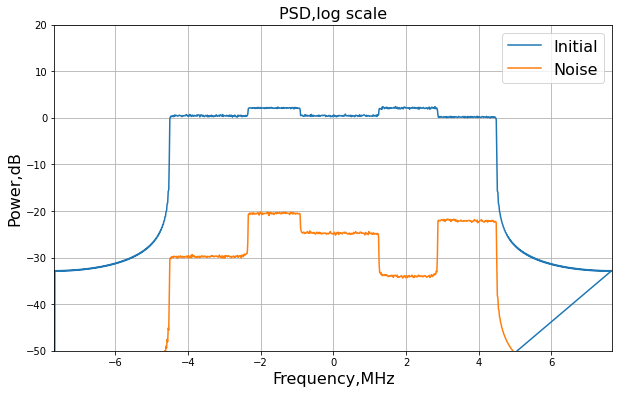

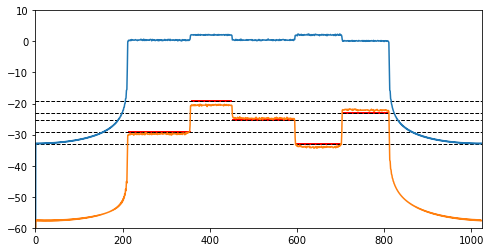

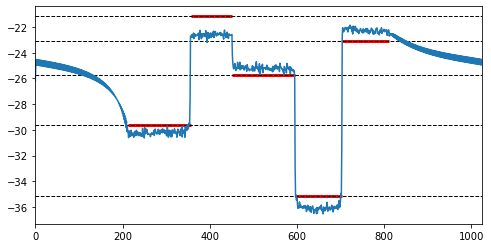

In [107]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES='PSD,log scale'
PSD = plots.plot_spectrum(SIGNALS,LABELS,TITLES,cfg,PSD_SIZE)
plots.plot_PSD(ANL_allocation,SC,PSD,cfg)

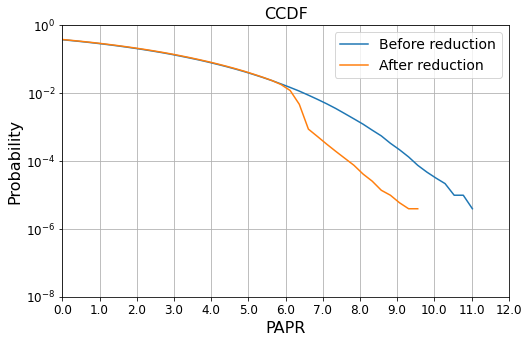

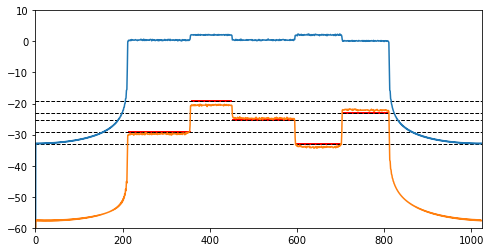

PAPR_mean before reduction tensor(8.6783, device='cuda:0')
PAPR_mean after reduction tensor(6.9793, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.6990, device='cuda:0')
Max PAPR reduction:  tensor(1.4744, device='cuda:0')


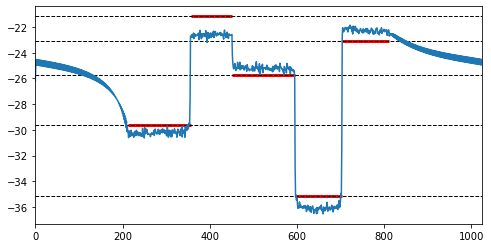

In [108]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)
plots.plot_PSD(ANL_allocation,SC,PSD,cfg)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean2 = PAPR.mean()

print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean2)
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_papr_idx0])